Import all the packages etc we are going to use

In [19]:
import pandas as pd
from sqlalchemy import create_engine # database connection
import datetime as dt
import csv # read csv files, dont write your own parser!
from pathlib import Path
import os
import string

This lots sets up the plotting packages so that the plots etc appear inline (ie in the browser window) instead of as separate windows

In [20]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

This process each file in turn in the give directory.
* Checks the file name ends with .csv (just in case left any zip or other files in there)
* It then reads the first two lines of the file to get the id of the site (LegacyID)
* Using pandas it then reads the rest of the file into a dataframe and adds the LegacyID to each row

In [21]:

def process_files(in_dir):
    in_path = Path(in_dir)
    for nfile, file in enumerate(in_path.iterdir()):
        if file.name.endswith('.csv'):
            with file.open('r') as f:
                csv_reader = csv.DictReader(f)
                header = next(csv_reader)
                fields = header[' Site Name'].split(';')
                header['Site Name'] = fields[0]
                header['GPS Ref'] = fields[1]

                df = pd.read_csv(str(file), skiprows=3)
                df['LegacyID'] = int(header['Legacy ID'])
                if nfile % 20 == 0:
                    print('Done %d files' % nfile)
                yield df
                

Get a connection to the MySQL server I have installed

The password is hidden in an environment variable (not that secure but better than just having it in plain text here)

In [22]:
#disk_engine = create_engine('sqlite:///traffic.db')
disk_engine = create_engine('mysql+mysqldb://root:%s@localhost/traffic' % os.environ['MYSQL_PASSWORD'])

Now we do the main loop 
* scan the directory with all the files in
* Clean up the column names a bit (take out all the spaces)
* Join the Local Date and Local Time columns together to get one column
* Keep only the columns we are interested in, add one new column
* Then tell pandas to put it in the database

In [23]:
not_done_index = True
for df in process_files('c:/dev/lse/midas'):
    df = df.rename(columns={c: c.replace(' ', '') for c in df.columns})
    df['LocalDateTime'] = pd.to_datetime(df['LocalTime']+' '+df['LocalDate'], format='%H:%M:%S %d/%m/%Y')
    columns = ['LegacyID','LocalDateTime','TotalCarriagewayFlow','SpeedValue']
    for c in df.columns:
        if c not in columns:
            df = df.drop(c, axis=1)
    df['hour'] = df['LocalDateTime'].dt.hour
    df.to_sql('data', disk_engine, if_exists='append')
    if not_done_index:
        disk_engine.execute('create index idx_hour on data (hour)')
        disk_engine.execute('create index idx_lid on data (LegacyID)')
        not_done_index = False
    

Done 0 files
Done 20 files
Done 40 files
Done 60 files


KeyboardInterrupt: 

Now we can start getting the database back out of the database and looking at it.

First get all the rows for after 10PM and before 5AM

In [12]:
df = pd.read_sql_query('SELECT LegacyID, TotalCarriagewayFlow, LocalDateTime, hour '
                       'FROM data '
                       'WHERE hour > 22 or hour < 5', disk_engine)
df.head()

,LegacyID,TotalCarriagewayFlow,LocalDateTime,hour
0,10,7.00,2014-01-01 04:45:00,4
1,10,5.50,2014-01-01 04:30:00,4
2,10,3.00,2014-01-01 04:15:00,4
3,10,3.25,2014-01-01 04:00:00,4
4,10,4.50,2014-01-01 03:45:00,3


WARNING plotting this can take a LONG time!

In [ ]:
df2 = df.set_index(['LegacyID', 'LocalDateTime'])
df2['TotalCarriagewayFlow'].plot()

Get the data for one monitoring site for just January

In [29]:
df3 = pd.read_sql_query('''SELECT LegacyID, TotalCarriagewayFlow, LocalDateTime, hour
                       FROM data 
                       WHERE LocalDateTime between %(dt1)s and %(dt2)s  and LegacyID=%(id)s''', disk_engine,
                       params={'dt1': dt.datetime(2014,1,1), 'dt2': dt.datetime(2014,1,31), 'id': 120})


This makes Panda look at the data by time , so can plot it more easily

In [30]:
df3 = df3.set_index(['LocalDateTime'])

In [31]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2881 entries, 2014-01-01 09:15:00 to 2014-01-31 00:00:00
Data columns (total 3 columns):
LegacyID                2881 non-null int64
TotalCarriagewayFlow    2881 non-null float64
hour                    2881 non-null int64
dtypes: float64(1), int64(2)
memory usage: 90.0 KB


Plot out the total flow against hour

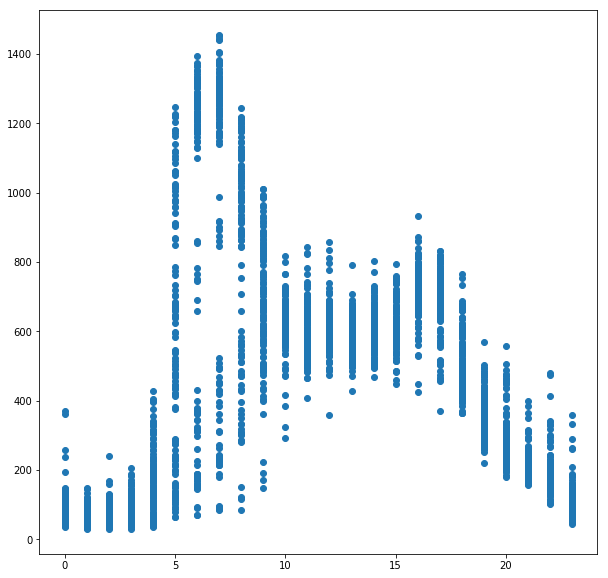

In [41]:
plt.scatter(df3['hour'],df3['TotalCarriagewayFlow'])

Average out by hour and plot it 

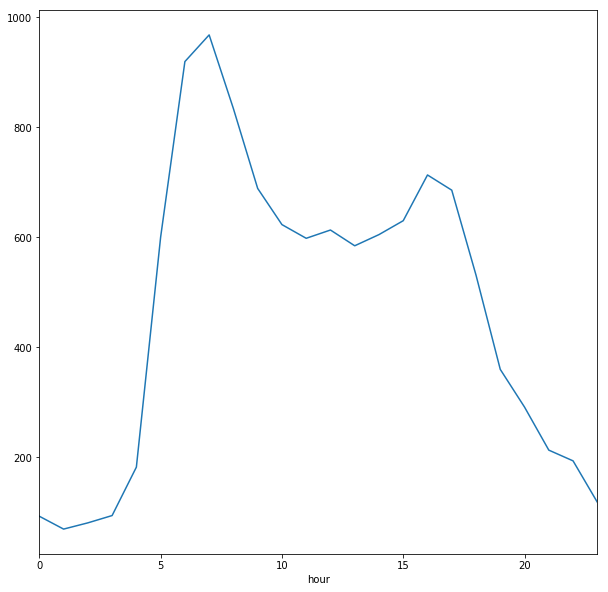

In [42]:

df3_byhour = df3.groupby(['hour'])
df3_byhour['TotalCarriagewayFlow'].mean().plot()


Again get data for a particular site, this time for the whole year but only the dark hours.
Add a column which roughly gives us the day of the lunar month

In [31]:
df4 = pd.read_sql_query('SELECT LegacyID, TotalCarriagewayFlow, LocalDateTime, hour, '
                        'DAYOFYEAR(LocalDateTime) %% 28  as lunar_day '
                       'FROM data '
                       'WHERE (hour > %(h1)s OR hour < %(h2)s) AND LegacyID=%(id)s', disk_engine,
                       params={'h1': 24, 'h2': 5, 'id': 120})

In [25]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 5 columns):
LegacyID                7300 non-null int64
TotalCarriagewayFlow    7300 non-null float64
LocalDateTime           7300 non-null datetime64[ns]
hour                    7300 non-null int64
lunar_day               7300 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 285.2 KB


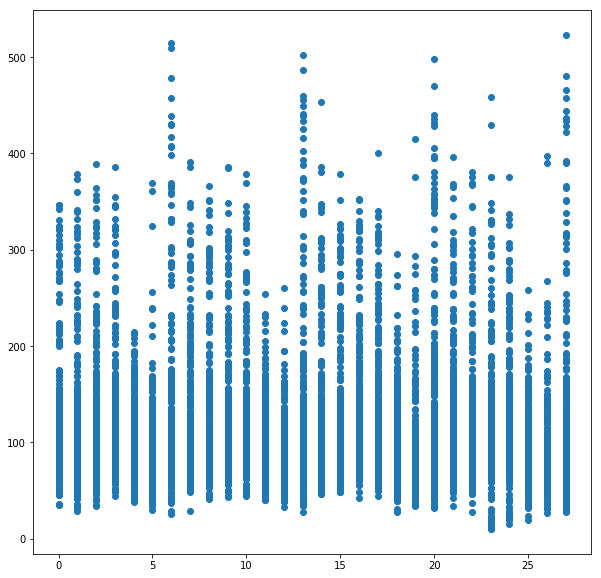

In [26]:
plt.scatter(df4['lunar_day'],df4['TotalCarriagewayFlow'])

In [18]:
df4_by = df4.groupby(['lunar_day'])

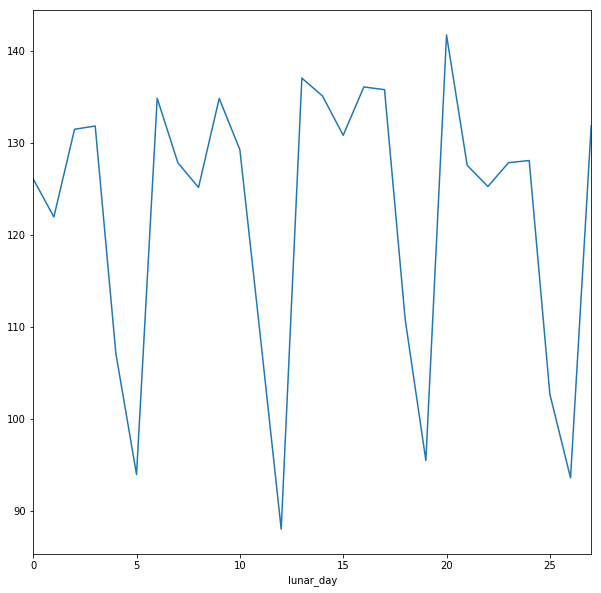

In [27]:
df4_by['TotalCarriagewayFlow'].mean().plot()

In [30]:
df5 = pd.read_sql_query('SELECT LegacyID, TotalCarriagewayFlow, LocalDateTime, hour, '
                        'DAYOFYEAR(LocalDateTime) %% 28  as lunar_day '
                       'FROM data '
                       'WHERE (hour > %(h1)s OR hour < %(h2)s) AND LegacyID=%(id)s', disk_engine,
                       params={'h1': 24, 'h2': 5, 'id': 101})

In [33]:
df5_by=df5.groupby(['lunar_day'])

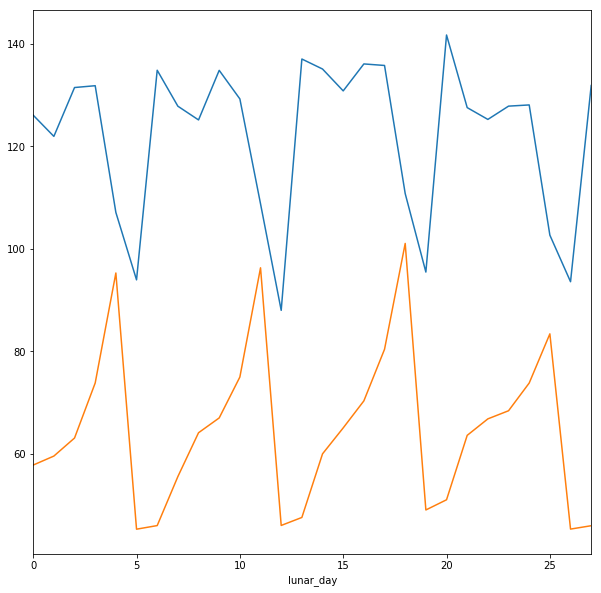

In [34]:
df4_by['TotalCarriagewayFlow'].mean().plot()
df5_by['TotalCarriagewayFlow'].mean().plot()